# The Receiver

## Introduction
The receiver for the sound-based move tracking protocol is in charge of decoding a sequence of face turns from the transmitted audio.

To do this, the receiver must go through the following steps:
- Record the transmitted audio.
- Measure the audible frequencies at each time step.
- Convert each time step's audible frequencies to the cube's state at that moment.
- Decode the applied face turns from the sequence of cube states.


This chapter will describe the development of a software algorithm in Python that can serve as a receiver for this sound-based move tracking protocol. 
This development began with the creation of synthetic audio recordings representing the tones that would be emitted by a Rubik's Cube equipped with an ideal transmitter (Section \ref{sec:synthetic-audio-generation}) followed by the implementation of an algorithm capable of decoding that ideal synthetic audio (Section \ref{sec:decoding-synthetic-audio}).
The algorithm was then made more robust by adding realistic noise to the synthetic audio to better simulate a real speedcubing environment (Section \ref{sec:adding-realistic-noise}) followed by enhancing the previously designed algorithm to continue to decode the applied move sequence in the midst of the added noise (Section: \ref{sec:decoding-realistic-noise}).

## Synthetic Audio Generation
The first step of designing a receiver is to synthesize an audio signal representative of the output of the ideal receiver.

This is done by encoding the frequency corresponding to each centerpiece state (Section \ref{subsec:represent-audio-protocol}), creating a virtual Rubik's Cube (Section \ref{subsec:represent-rubiks-cube}), and finally generating the audio signal from the virtual Rubik's Cube's state (Section \ref{subsec:generate-audible-algorithm}).

### Representing the Audio Protocol
For the synthetic audio generator to produce a realistic signal, it needs to know which frequencies to transmit for each centerpiece state. 
For this design the frequencies listed in Table \ref{table:centerpiece-frequencies} are converted to a dictionary.

In [20]:
CENTERPIECE_ROTATION_TO_FREQUENCY_MAPPINGS = {
    "U": {
        0: 800,
        1: 900,
        2: 1000,
        3: 1100,
    },
    "D": {
        0: 1300,
        1: 1400,
        2: 1500,
        3: 1600,
    },
    "R": {
        0: 1800,
        1: 1900,
        2: 2000,
        3: 2100,
    },
    "L": {
        0: 2300,
        1: 2400,
        2: 2500,
        3: 2600,
    },
    "F": {
        0: 2800,
        1: 2900,
        2: 3000,
        3: 3100,
    },
    "B": {
        0: 3300,
        1: 3400,
        2: 3500,
        3: 3600,
    }
}

With this dictionary in place, determining the frequency to transmit for any particular centerpiece's current rotation is reduced to a simple lookup.

In [21]:
def frequency_of(centerpiece: str, rotation: int) -> float:
    return CENTERPIECE_ROTATION_TO_FREQUENCY_MAPPINGS[centerpiece][rotation]

### Representing the Rubik's Cube
Next, the synthetic audio generator needs a representation of a Rubik's Cube on which face turns can be virtually applied, and the resulting cube state can be read out.

In [22]:
class RubiksCube:
    
    CLOCKWISE = 1
    COUNTERCLOCKWISE = 3

    def __init__(self):
        self.state = { "U": 0, "D": 0, "R": 0, "L": 0, "F": 0, "B": 0 }
    
    def apply_move(self, move: str):
        # Extract the face and direction from the move string.
        face = move[0]
        if len(move) == 1:                             # e.g. U
            direction = RubiksCube.CLOCKWISE
        else:                                          # e.g. U'
            direction = RubiksCube.COUNTERCLOCKWISE
        # Update the state to apply the move.
        self.state[face] = (self.state[face] + direction) % 4

### Generating Synthetic Audio for an Arbitrary Algorithm
Now the synthetic audio can be generated for any valid algorithm.
This is done using the "tones" library \cite{pip-tones} created by Erik Nyquist.
First, a separate audio track is created for each centerpiece on the cube and the frequencies representing the initial state of each centerpiece are added to its corresponding audio track.
From there, the rest of the synthetic audio can be created by iterating through each step of the given algorithm, applying it to the virtual Rubik's Cube, and adding the frequency for each centerpiece's resulting state to its corresponding audio track.

In [23]:
from tones.mixer import Mixer  # https://pypi.org/project/tones/
from tones import SINE_WAVE
    
def _create_mixer(rubiks_cube: RubiksCube) -> Mixer:
    mixer: Mixer = Mixer(sample_rate=44100, amplitude=1)
    # Add a separate track for each centerpiece.
    for face, _ in rubiks_cube.state.items():
        mixer.create_track(face, SINE_WAVE, attack=0, decay=0)
    return mixer

def _render_cube_state(mixer: Mixer, rubiks_cube: RubiksCube, tps: float):
    for face, rotation in rubiks_cube.state.items():
        mixer.add_tone(face, frequency_of(face, rotation), duration=1 / tps)

def render_audible_alg(alg: str, wav_path: str=None, tps: float=4):
    # Create the virtual Rubik's Cube.
    rubiks_cube: RubiksCube = RubiksCube()
    
    # Create the audio mixer used to create the synthesized audio.
    mixer = _create_mixer(rubiks_cube)
    
    # Add the initial cube state to the mixer.
    _render_cube_state(mixer, rubiks_cube, tps)
    
    # Iterate over the moves in the algorithm, adding
    # the cube state to the mixer after each move.
    moves = alg.split(" ")
    for move in moves:
        rubiks_cube.apply_move(move)
        _render_cube_state(mixer, rubiks_cube, tps)
    
    # Save the final audio to a .wav file.
    mixer.write_wav(wav_path if wav_path else f"{alg}.wav")

With these functions in place, synthetic audio can be easily created for any valid Rubik's Cube algorithm. For example, generating synthetic audio that sweeps through every possible centerpiece state can be done with the following snippet of code:

In [24]:
demo_alg = "U U U U D D D D R R R R L L L L F F F F B B B B"
demo_wav_path = "demo_all_states.wav"
render_audible_alg(demo_alg, demo_wav_path)

## Decoding Move Sequences from Synthetic Audio
With synthetic audio now available for any valid Rubik's Cube algorithm, the next step is to create an initial software algorithm that can decode that audio back into the original move sequence.

TODO summarize the subsections that make this possible.

### Compute the Spectrogram
The first step in decoding the synthetic audio is determining its component frequencies at any specific moment in time.
These component frequencies can be easily visualized using a spectrogram, like the one in Figure \ref{fig:spectrogram} of the synthetic audio created in Section \ref{subsec:generate-audible-algorithm}.

![spectrogram]("./thesis/draft/Figures/5 Algorithm Design/component_frequencies.png")


The bright, horizontal yellow bands in the spectrogram represent the component frequencies present in the audio signal at each point in time.
The vertical red line on the spectrogram indicates the specific slice of the spectrogram represented by the graph of the component frequencies at that specific point in time.

While the Figure \ref{fig:spectrogram} was created using Matplotlib's specgram plot, the actual data of the spectogram for a given .wav file can be easily obtained using the numpy and scipy packages

In [25]:
import numpy as np
from scipy import signal
from scipy.io import wavfile

def compute_spectrogram(wav_path: str):
    SAMPLES_PER_WINDOW = 1024  # Balances frequency/time precision
    sample_rate, audio_samples = wavfile.read(wav_path)
    freq, time, Zxx = signal.stft(audio_samples, fs=sample_rate,
        nperseg=SAMPLES_PER_WINDOW, noverlap=(SAMPLES_PER_WINDOW // 4) * 3)
    spectrogram = np.abs(Zxx).transpose()
    return freq, time, spectrogram

#### Visualization

In [26]:
# Heavily aided by https://matplotlib.org/stable/gallery/animation/simple_anim.html#sphx-glr-gallery-animation-simple-anim-py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy import signal
from scipy.io import wavfile

def compute_threshold(values: list):
    return -500  # Out of sight of the chart

def animate(wav_path: str, alg: str):
    # Parse the audio sample into its spectrogram
    SAMPLES_PER_WINDOW = 1024  # Seems to balance frequency precision with time precision.
    sample_rate, audio_samples = wavfile.read(wav_path)
    freq, time, Zxx = signal.stft(audio_samples, fs=sample_rate,
        nperseg=SAMPLES_PER_WINDOW, noverlap=(SAMPLES_PER_WINDOW // 4) * 3)
    spectrogram = np.abs(Zxx).transpose()

    # Generate the plots
    fig, (ax_spectrogram, ax_fourier) = plt.subplots(2)

    # Set the spectrogram
    ax_spectrogram.specgram(audio_samples, Fs=sample_rate, 
        NFFT=SAMPLES_PER_WINDOW,
        noverlap=SAMPLES_PER_WINDOW // 4 * 3)  # 3/4 of the window size
    line_spectrogram, = ax_spectrogram.plot([], [], '-', color='red')
    time_tracker_spectrogram = ax_spectrogram.axvline(0, color='red')
    ax_spectrogram.set_ylim(0, 5000)
    ax_spectrogram.set_title(f"Spectrogram")
    ax_spectrogram.set_ylabel('Frequency [Hz]')
    ax_spectrogram.set_xlabel('Time [sec]')

    # Set the Fourier transform
    STEP = 10
    indices = np.arange(0, len(time) + 1, step=STEP)
    line_fourier, = ax_fourier.plot(freq, spectrogram[0], color='red')
    threshold_fourier = ax_fourier.axhline(-500, color='green')
    ax_fourier.set_title("")
    ax_fourier.set_xlim(0, 5000)  # Frequency
    ax_fourier.set_xlabel("Frequency [Hz]")
    ax_fourier.set_ylim(0, np.amax(spectrogram))  # Strength
    ax_fourier.set_ylabel("Strength")

    # Space figures nicely
    fig.suptitle(alg)
    fig.tight_layout(h_pad=3)

    def draw_frame_at(i):
        time_tracker_spectrogram.set_xdata(time[i])
        line_fourier.set_ydata(spectrogram[i])
        threshold_fourier.set_ydata(compute_threshold(spectrogram[i]))
        ax_fourier.set_title(f"Frequencies at {time[i]:.2f} seconds [idx={i}]")
        return line_spectrogram, line_fourier

    ani = animation.FuncAnimation(fig, draw_frame_at,
        frames=indices, interval=1, blit=True, save_count=len(time)/STEP)
    ani.save(f"plt/animation/{wav_path[:-4]}.mp4",
        fps=len(time)/STEP/5, dpi=300)
    plt.show()


c:\Users\Joseph Hale\git\DIY-Supercube\venv\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


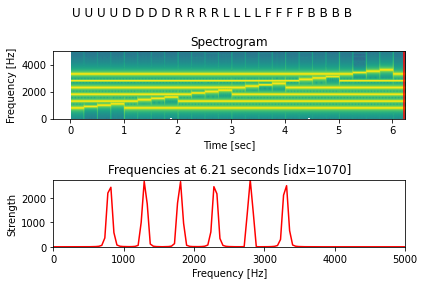

In [27]:
# animate(demo_wav_path, demo_alg)

### Extract the Dominant Component Frequencies
Notice how the component frequency graph in Figure \ref{fig:spectrogram} has six peaks: these are the transmitted frequencies representing the current state of the virtual Rubik's Cube's six centerpieces at that specific instant of time.

The exact frequencies of these peaks can be extracted by filtering out all frequencies not above a specific threshold.
In this case, a simple threshold of 85\% of the maximum strength of any component frequency (see the green line in Figure \ref{fig:spectrogram-with-naive-threshold}) isolates the peak of the six dominant component frequencies.

![threshold]("./thesis/draft/Figures/5 Algorithm Design/threshold.png")


Using the actual spectogram data we can compute the exact values of these peaks.

In [28]:
def compute_threshold(values: list):
    return max(values) * 0.85

def extract_important_frequencies(freq, time, spectrogram, time_idx):
    important_freqs = []
    threshold = compute_threshold(spectrogram[time_idx])
    for freq_idx in range(len(freq)):
        if spectrogram[time_idx][freq_idx] > threshold:
            important_freqs.append(dict(
                hz=freq[freq_idx],
                power=spectrogram[time_idx][freq_idx]
            ))
    return important_freqs

freq, time, spectrogram = compute_spectrogram(demo_wav_path)
important_freqs = extract_important_frequencies(freq, time, spectrogram,
    time_idx=310) # 1.80 seconds

important_freqs_hz = [i["hz"] for i in important_freqs]
pretty_freqs = list(map(lambda x: f"{x:.0f} Hz", important_freqs_hz))
print(pretty_freqs)

['818 Hz', '1593 Hz', '1809 Hz', '2283 Hz', '2799 Hz', '3316 Hz']


In [29]:
# animate(demo_wav_path, demo_alg)

### Translating Component Frequencies to Centerpiece States
With the specific frequencies of each detected peak, the original state of the Rubik's Cube at that moment in time can be computed by finding the state whose corresponding frequency is closest to each detected peak frequency.

In [30]:
def _closest_state(detected_freq):
    closest_rotation = None
    closest_difference = None
    for face, rotations in CENTERPIECE_ROTATION_TO_FREQUENCY_MAPPINGS.items():
        for rotation, freq in rotations.items():
            difference = abs(detected_freq - freq)
            if closest_difference is None or difference < closest_difference:
                closest_difference = difference
                closest_rotation = dict(face=face, rotation=rotation)
    return closest_rotation

def get_state_from_freqs(important_freqs: list) -> dict:
    state = {}
    for freq in important_freqs:
        hz, power = freq.values()
        closest_state = _closest_state(hz)
        state[closest_state['face']] = closest_state['rotation']
    return state

print(get_state_from_freqs(important_freqs))

{'U': 0, 'D': 3, 'R': 0, 'L': 0, 'F': 0, 'B': 0}


Repeating this process for each time step in the recorded audio will yield a sequence of the Rubik's Cube's centerpiece states over the course of the recorded audio sequence.

In [31]:
def get_state_over_time(freq, time, spectrogram):
    state_over_time = []
    for time_idx in range(len(time)):
        important_freqs = extract_important_frequencies(
            freq, time, spectrogram, time_idx)
        state = get_state_from_freqs(important_freqs)
        state_over_time.append(dict(
            time=time[time_idx],
            state=state
        ))
    return state_over_time

state_over_time = get_state_over_time(freq, time, spectrogram)

### Extracting Move Sequences from Centerpiece State Sequences
Finally, the original move sequence can be recovered by iterating over the sequence of cube states, and registering any change to the cube state as a move applied to the cube.

In [32]:
def _move_from(face, current_rotation, new_rotation):
    direction = None
    if (current_rotation + RubiksCube.CLOCKWISE) % 4 == new_rotation:
        direction = ""  # Clockwise
    elif (current_rotation + RubiksCube.COUNTERCLOCKWISE) % 4 == new_rotation:
        direction = "'" # Counterclockwise
    return f"{face}{direction}"

def detect_moves(state_over_time):
    detected_moves = []
    current_state = {}
    for idx, timed_state in enumerate(state_over_time):
        time, state = timed_state.values()
        for face, rotation in state.items():
            if not (face in current_state):
                current_state[face] = rotation
            if rotation != current_state[face]:
                detected_moves.append(dict(
                    time=time,
                    move=_move_from(face, current_state[face], rotation)
                ))
                current_state[face] = rotation
    return detected_moves

detected_moves = detect_moves(state_over_time)

pretty_moves = " ".join([i["move"] for i in detected_moves])
print(pretty_moves)   
print(f"Matches demo_alg? {demo_alg == pretty_moves}") 

U U U U D D D D R R R R L L L L F F F F B B B B
Matches demo_alg? True


Clearly, the detected move sequence matches the demo algorithm used to create the synthetic audio in Section \ref{subsec:generate-audible-algorithm}, which means this algorithm is a functional receiver for an ideal transmitter.

*Side Note: Here's the full implementation for a second example. This is provided here so it's easy to find a complete example for detecting a new algorithm even though it's not included in the main Thesis document.*

In [11]:
# demo2_alg = "U U' D D' R R' L L' F F' B B'"
# demo2_wav_path = "demo_all_turns.wav"
# render_audible_alg(demo2_alg, demo2_wav_path)

# freq2, time2, spectrogram2 = compute_spectrogram(demo2_wav_path)
# state_over_time2 = get_state_over_time(freq2, time2, spectrogram2)
# detected_moves2 = detect_moves(state_over_time2)

# pretty_moves2 = " ".join([i["move"] for i in detected_moves2])
# print(pretty_moves2)
# print(f"Matches demo2_alg? {demo2_alg == pretty_moves2}")

## Adding Realistic Noise to Synthetic Audio

In [33]:
# NOT FOR INCLUSION IN THE THESIS, LEGACY MAPPINGS USED IN TRANSMITTED SIGNAL
CENTERPIECE_ROTATION_TO_FREQUENCY_MAPPINGS = {
	"U": {
		0: 799.872020476724,
		1: 899.604174163368,
		2: 1000.40016006403,
		3: 1100.5943209333
	},
	"D": {
		0: 1250.93820365274,
		1: 1350.25654874426,
		2: 1448.85540423066,
		3: 1549.42671211652,
	},
	"R": {
		0: 1700.68027210884,
		1: 1799.20834832674,
		2: 1899.69604863222,
		3: 2000.80032012805,
	},
	"L": {
		0: 2296.73863114378,
		1: 2497.5024975025,
		2: 2695.41778975741,
		3: 2903.60046457607,
	},
	"F": {
		0: 3203.07495195388,
		1: 3401.36054421769,
		2: 3607.50360750361,
		3: 3799.39209726444,
	},
	"B": {
		0: 4105.09031198686,
		1: 4302.92598967298,
		2: 4492.36298292902,
		3: 4699.24812030075
	}
}

## Decoding the Realistic Audio

### Fine-Tuning the Threshold

In [34]:
def compute_threshold(values: list, stdv_pct: float=1, min_thresh: int=50):
    return max(min_thresh, np.std(values) * stdv_pct)

### Filtering through similar peak frequencies

In [35]:
def get_state_from_freqs(important_freqs: list) -> dict:
    state = {}
    state_power = {"U": 0, "D": 0, "R": 0, "L": 0, "F": 0, "B": 0}  # New
    for freq in important_freqs:
        hz, power = freq.values()
        closest_state = _closest_state(hz)
        if power > state_power[closest_state["face"]]:              # New
            state[closest_state["face"]] = closest_state["rotation"]
            state_power[closest_state["face"]] = power              # New
    return state

transmitted_wav_path = "transmitted-356-5tps.wav"
freq, time, spectrogram = compute_spectrogram(transmitted_wav_path)
important_freqs = extract_important_frequencies(freq, time, spectrogram,
    time_idx=800) # 4.64 seconds
print(get_state_from_freqs(important_freqs))

{'U': 0, 'D': 0, 'R': 0, 'L': 0, 'F': 0, 'B': 0}


### Ignoring Noise when Extracting Move Sequences

In [51]:
def detect_moves(state_over_time, window_size=8):                       # Edit
    detected_moves = []
    current_state = {}
    new_state = {"U": -1, "D": -1, "R": -1, "L": -1, "F": -1, "B": -1}  # New
    new_state_idx = {"U": 0, "D": 0, "R": 0, "L": 0, "F": 0, "B": 0}    # New
    for idx, timed_state in enumerate(state_over_time):
        time, state = timed_state.values()
        for face, rotation in state.items():
            # Update new_state whenever the rotation changes
            if rotation != new_state[face]:
                new_state[face] = rotation
                new_state_idx[face] = idx
            # If the new state has persisted over window_size time steps...
            if idx - new_state_idx[face] == window_size:
                if not (face in current_state):
                    current_state[face] = new_state[face]
                # ... and it's a different rotation than the current state...
                elif new_state[face] != current_state[face]:
                    # ... then we have detected a face turn!
                    detected_moves.append(dict(
                        time=state_over_time[new_state_idx[face]]["time"],
                        move=_move_from(face, current_state[face], rotation)
                    ))
                    current_state[face] = rotation
                    new_state_idx[face] = 0
    return detected_moves

state_over_time = get_state_over_time(freq, time, spectrogram)
detected_moves = detect_moves(state_over_time)

pretty_moves = " ".join([i["move"] for i in detected_moves])
print(pretty_moves)   
print(f"Matches demo_alg? {demo_alg == pretty_moves}")

U U U U D D D D R R R R L L L L F F F F B B B B
Matches demo_alg? True
